# **Лабораторная работа 3**

По предмету: **Анализ защищенности систем искусственного интеллекта**

Выполнил студент **2 курса** группы **ББМО-02-23**

**Панков Евгений Ромуальдович**

## 1. Начнем с утановки библиотеки `TF-KERAS-VIS` — набор инструментов визуализации для отладки `tf.keras.Model` в `Tensorflow2.0+`:

In [29]:
!pip install tf-keras-vis

## 2. Также загрузим нужные для работы библиотеки:

In [30]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import tensorflow as tf
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16 as Model

## Зугрузим случайные изображения:

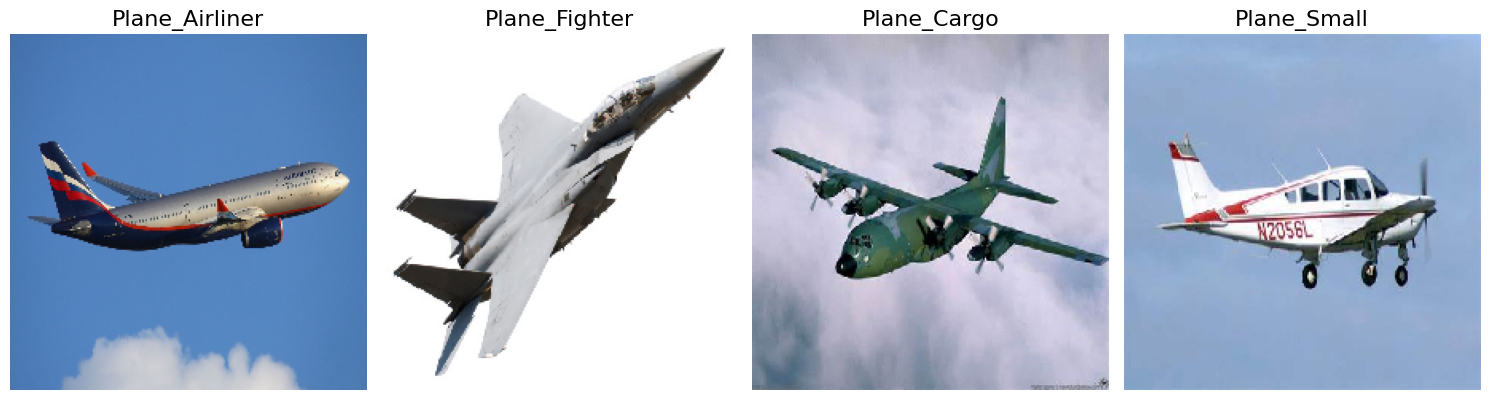

In [31]:
# Загружаем предобученную модель VGG16 с весами ImageNet:
model = Model(weights='imagenet', include_top=True)
# Создадим списки изображений и путей к ним для загрузки:
imgTitleList = ['Plane_Airliner', 'Plane_Fighter', 'Plane_Cargo', 'Plane_Small']
imgPathList = ['Plane_Airliner.jpg', 'Plane_Fighter.jpg', 'Plane_Cargo.jfif', 'Plane_Small.jfif']
# Загружаем изображения:
imgArr = np.asarray([np.array(load_img(imgPath, target_size=(224, 224))) for imgPath in imgPathList])
# Предобрабатываем изображения для подачи в модель (нормализация и изменение формата):
X = preprocess_input(imgArr)
# Визуализируем изображений:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for i, title in enumerate(imgTitleList):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(imgArr[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Поменяем функцию активации последнего слоя на линейную, зададим метки классов выбранным изображениям:

In [32]:
# Меняем активацию последнего слоя модели на линейную:
replace2linear = ReplaceToLinear()
def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear
# Определяем функцию для получения оценок по выходным данным модели:
score = CategoricalScore([726, 895, 726, 726])
def score_function(output):
    return (output[0][726], output[1][895], output[2][726], output[3][726])

## Отобразим карту значимости различных областей изображения:

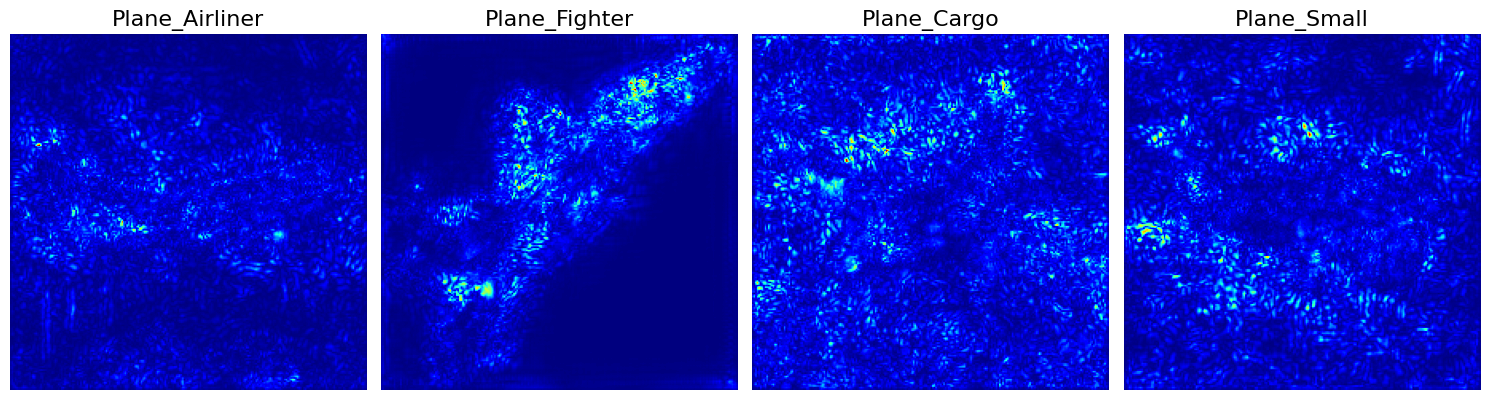

In [33]:
# Создаем объект Saliency для вычисления карты значимости:
saliency = Saliency(model, model_modifier=replace2linear, clone=True)
# Вычисляем карты значимости для заданных входных данных X с использованием заданного объекта score:
mapList = saliency(score, X)
# Отображаем полученные карты значимости:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for i, title in enumerate(imgTitleList):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(mapList[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Добавим сглаживания для улучшения наглядности полученных ранее карт знаимости:

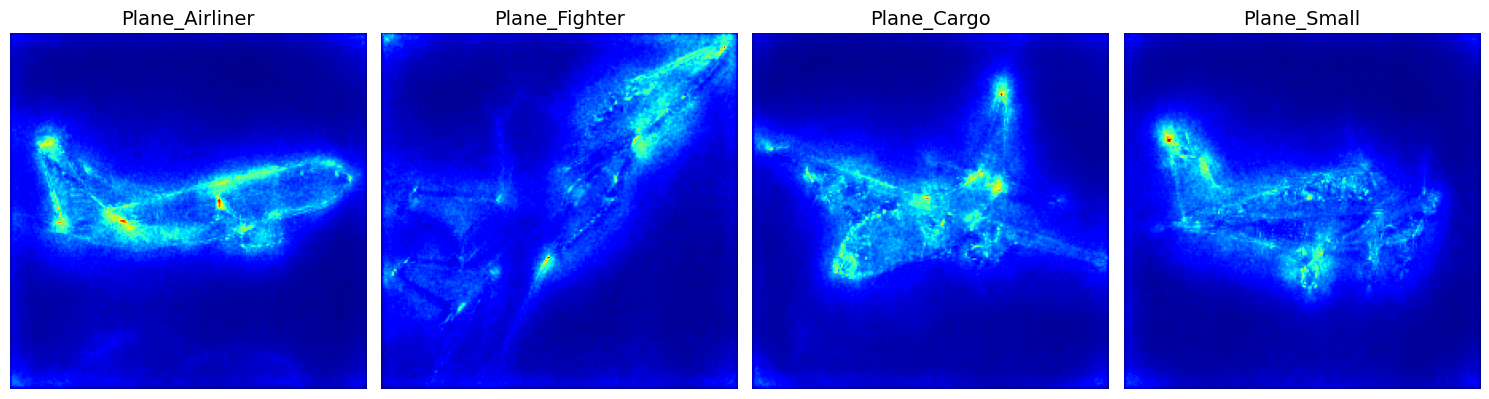

In [34]:
# Добавляем параметры для реализации сглаживания:
mapList = saliency(score, X, smooth_samples=90, smooth_noise=0.25)
# Отображаем полученные сглаженные карты значимости:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for i, title in enumerate(imgTitleList):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(mapList[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

**Вышеописанные действия позволяют нам увидеть, на какие области изображения обращает внимание нейронная сеть при определении конкретного класса.**

## Далее используем метод Gradcam для лучшей передачи важности признаков:

Этот метод содержит больше пространственных деталей, которые теряются в плотных слоях.

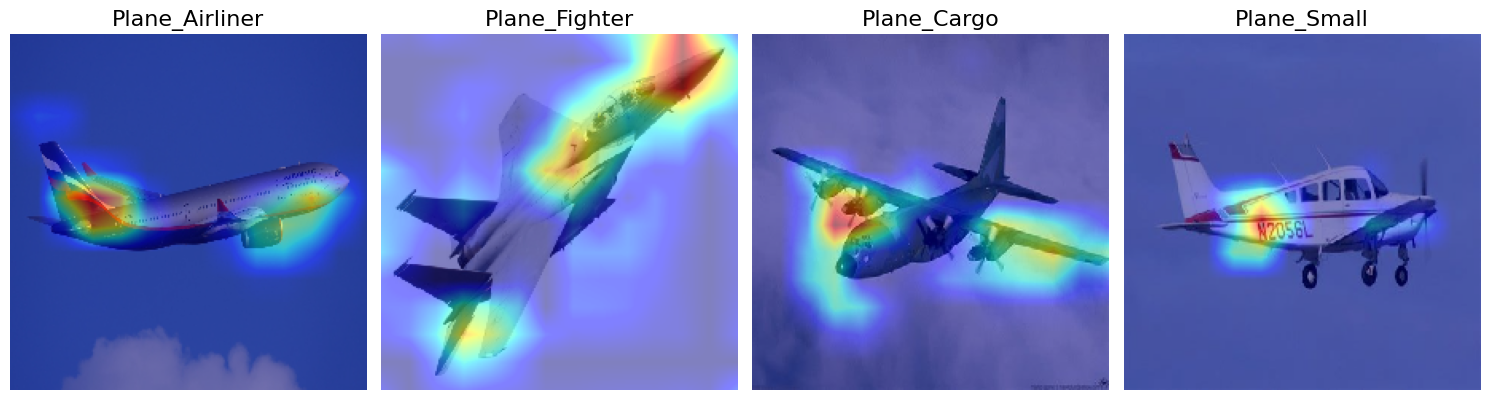

In [35]:
# Создаем объект Gradcam для вычисления карт по методу Grad-CAM:
gradcam = Gradcam(model, model_modifier=replace2linear, clone=True)
# Вычисляем карты Grad-CAM для заданных входных данных X, указывая предпоследний слой:
mapList = gradcam(score, X, penultimate_layer=-1)
# Визуализируем полученные изображения:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for i, title in enumerate(imgTitleList):
    # Преобразуем карту значимости в формат изображения (целочисленный) с использованием цветовой карты 'jet':
    # Применяем цветовую карту и масштабируем значения:
    heatmap = np.uint8(cm.jet(mapList[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(imgArr[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## Используем метод Gradcam++, как улучшенный вариант предыдущего метода:

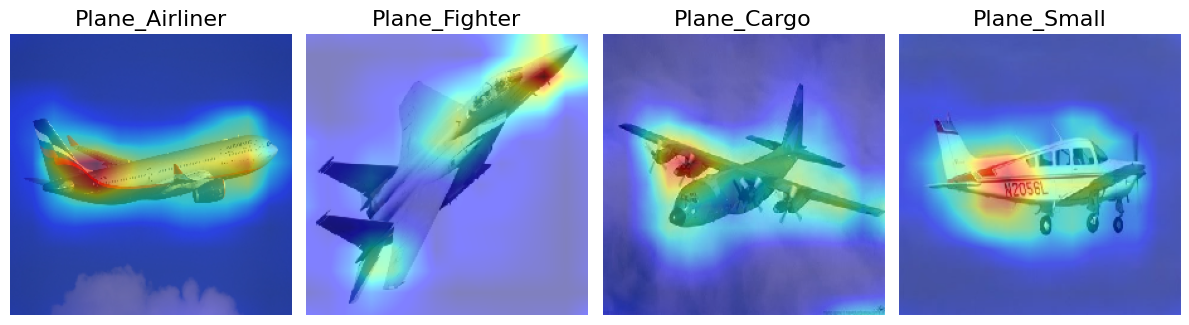

In [36]:
# Создаем объект GradcamPlusPlus для вычисления карт по методу Grad-CAM++:
gradcam = GradcamPlusPlus(model, model_modifier=replace2linear, clone=True)
# Вычисляем карты GradcamPlusPlus для заданных входных данных X, указывая предпоследний слой:
mapList = gradcam(score, X, penultimate_layer=-1)
# Визуализируем полученные изображения:
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(imgTitleList):
    heatmap = np.uint8(cm.jet(mapList[i])[..., :4] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(imgArr[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

**Как видим, данный метод немного изменяет результат в лучшую сторону.**

## Вывод:

Использование методов визуализации, таких как `Grad-CAM`, `Grad-CAM++`, `Saliency` и `SmoothGrad`, играет важную роль в понимании работы моделей машинного обучения. Эти инструменты помогают выявить, какие части изображений оказывают наибольшее влияние на процесс принятия решений.

Методы `Grad-CAM` и `Grad-CAM++` позволяют детально визуализировать активации в разных областях изображения. Это дает возможность понять, на каких элементах модель сосредотачивает своё внимание при классификации. Карты активаций служат полезным инструментом для анализа ключевых объектов или деталей, которые были определяющими для принятия решения.

Кроме того, метод `SmoothGrad` помогает уменьшить шум в визуализациях, что делает карты активации более понятными и интерпретируемыми